# Colorization
Class project - CS231N - Stanford University

Vincent Billaut  
Matthieu de Rochemonteix  
Marc Thibault  

See our GitHub [repo](https://github.com/vincentbillaut/all-colors-matter) for more details on the implementation.

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from matplotlib.pyplot import imread
from matplotlib import animation
from IPython.display import display, HTML
from tqdm import tqdm_notebook

####################################################
# Setting working directory to enable relative paths
import os
os.chdir("../")
import pickle
####################################################

from models.coloringmodel import Config
from models.naive_convnet import NaiveConvColoringModel
from models.unet import UNetColoringModel
from utils.dataset import Dataset
from utils.color_utils import RGB_to_YUV, YUV_to_RGB
from utils.data_utils import load_image_jpg_to_YUV
from utils.color_discretizer import ColorDiscretizer
from utils.data_augmentation import DataAugmenter
from utils.video_utils import smoothen_frame_list

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/marc/CS231N/all-colors-matter/utils/data_utils.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

## Load existing model

In [2]:
# Enter output folder name
output_folder = "outputs/20180604_223338-2cd6/"

In [3]:
config = Config("configs/config_unet_suncoast2.json")

cd = ColorDiscretizer(max_categories=config.max_categories)
cd_loaded = pickle.load(open("notebooks/cd.pkl", "rb"))
for k in cd_loaded.__dict__:
    cd.__dict__[k] = cd_loaded.__dict__[k]

Saving model outputs to outputs/20180607_001201-2b99/


# From here, run all to predict new images

In [ ]:
config.val_path = "data/postcards_processed_train/"

In [4]:
da = DataAugmenter()
dataset = Dataset(config.train_path, config.val_path, cd, da)
model = UNetColoringModel(config, dataset)

In [5]:
model.load(output_folder)

Saving model outputs to outputs/20180607_001202-b906/
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Restoring parameters from outputs/20180604_223338-2cd6/checkpoints/model
[UNetConvNet] Loaded model <outputs/20180604_223338-2cd6/checkpoints>


In [18]:
image_paths = [os.path.join(config.val_path, impath) for impath in os.listdir(config.val_path)]
image_paths = sorted(image_paths)

### Utility functions

In [21]:
temperatures = [.1, 1., 3.]
    
def output_prediction(image_paths, cd):
    n_images = len(image_paths)
    prediction_list = []
    yscale_list = []
    uvtruth_list = []
    for i, image_path in enumerate(tqdm_notebook(image_paths)):
        loss, pred_image_categories, (im_yscale, im_uvscale, msk) = model.pred_color_one_image(image_path)
        mask_shape = [0, 0]
        if msk[:, 0].mean() == 1.:
            mask_shape[0] = msk.shape[1]
        else:
            mask_shape[0] = np.argmin(msk[:, 0])
        if msk[0, :].mean() == 1.:
            mask_shape[1] = msk.shape[0]
        else:
            mask_shape[1] = np.argmin(msk[0, :])
        
        cropped_pred_image_categories = pred_image_categories[0, :mask_shape[0], :mask_shape[1], :]
        cropped_im_yscale = im_yscale[:mask_shape[0], :mask_shape[1]]
        cropped_im_uvscale = im_uvscale[:mask_shape[0], :mask_shape[1], :]
        
        prediction_list.append(cropped_pred_image_categories)
        yscale_list.append(cropped_im_yscale)
        uvtruth_list.append(cropped_im_uvscale)

    return prediction_list, yscale_list, uvtruth_list

def display_pred_array(prediction_list, yscale_list, uvtruth_list, cd):
    n_images = len(prediction_list)
    n_temperatures = len(temperatures)
    plt.figure(figsize=(16, n_images * 5))
    
    for i in range(n_images):
        pred_frame = prediction_list[i]
        yscale_frame = yscale_list[i]
        uvtruth_frame = uvtruth_list[i]
        

        true_YUV_image = np.concatenate([yscale_frame, uvtruth_frame], axis=2)
        true_RGB_image = YUV_to_RGB(true_YUV_image).astype("uint8")
        
        ax = plt.subplot(n_images, n_temperatures + 1, 1 + i * (n_temperatures + 1))
        plt.imshow(true_RGB_image)
        plt.axis('off')
        ax.set_title("ground truth")
        for j, temperature in enumerate(temperatures):
            pred_UVimage = cd.UVpixels_from_distribution(pred_frame,
                                                         temperature=temperature)
            predicted_YUV_image = np.concatenate([yscale_frame, pred_UVimage], axis=2)
            predicted_RGB_image = YUV_to_RGB(predicted_YUV_image).astype("uint8")

            ax = plt.subplot(n_images, n_temperatures + 1, 1 + i * (n_temperatures + 1) + j + 1)
            plt.imshow(predicted_RGB_image)
            plt.axis('off')
            ax.set_title("prediction (temperature = {})".format(temperature))
    
    plt.show()
    

In [23]:
prediction_list, yscale_list, uvtruth_list = output_prediction(image_paths, cd)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

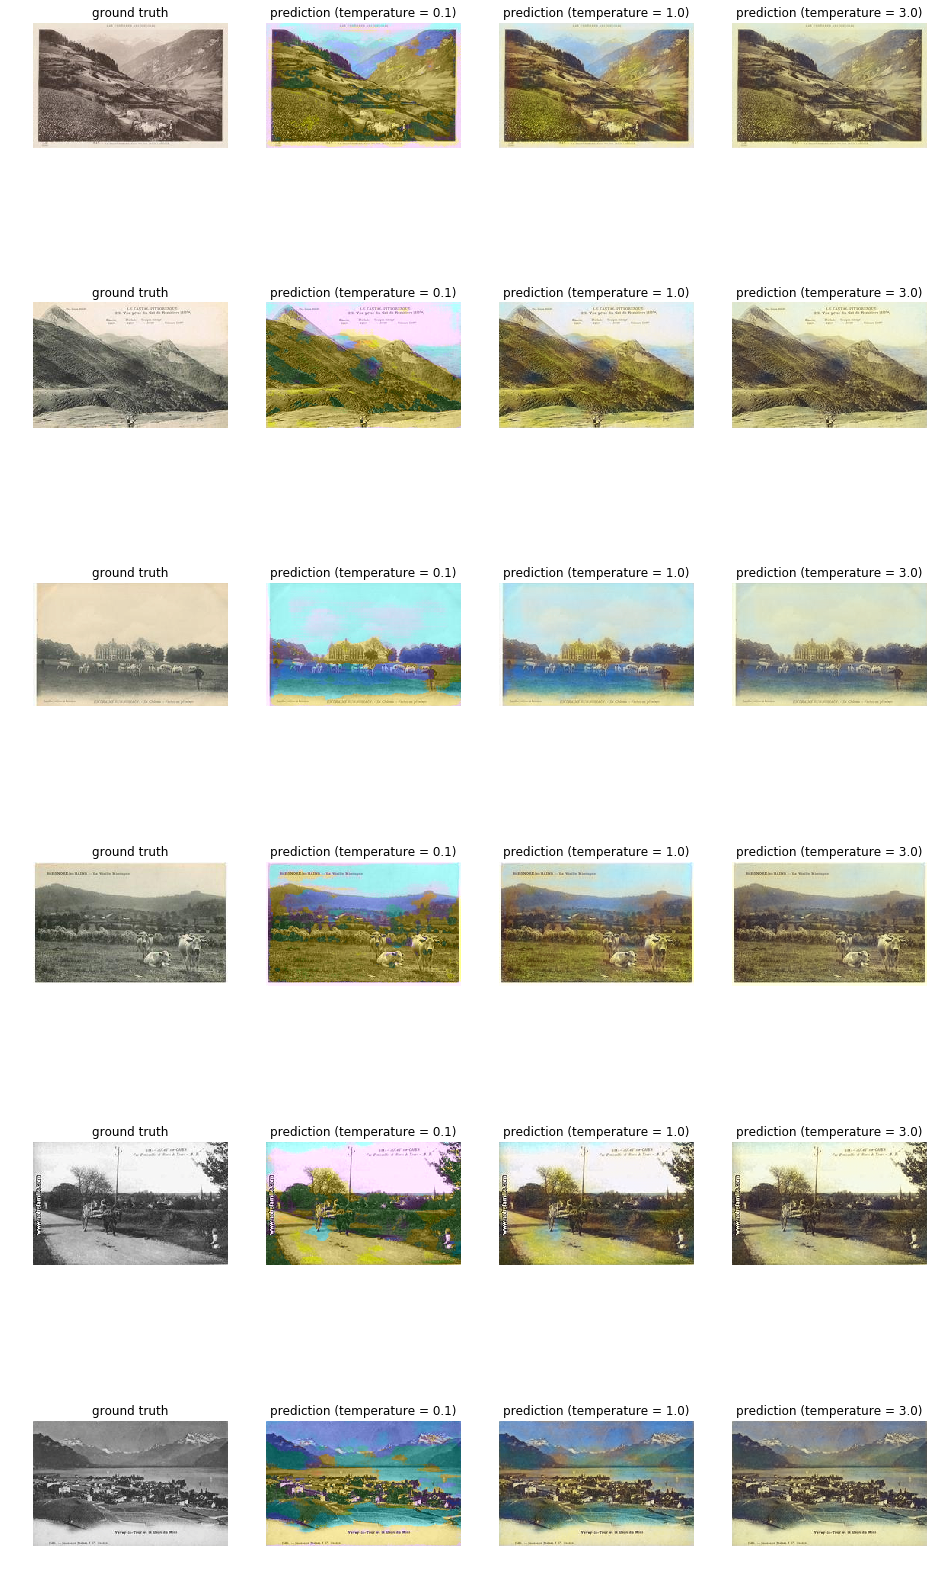

In [24]:
display_pred_array(prediction_list, yscale_list, uvtruth_list, cd)